# Cloud segmentation in python

There are several great notebooks to build on. For educational purposes, a nice way to learn about image segmentation is to use a [kernel starting from scratch](https://www.kaggle.com/code/dhananjay3/image-segmentation-from-scratch-in-pytorch), understand the architecture and then improve by borrowing other elements from other NBs.
Another pitfall to avoid while learning is to use high-level frameworks, convenient for prototyping but not for learning, as they may hide all the details

## Features of this NB
* Using the Unet Architecture
* Deterministic behaviour for reproducibility
* K-fold cross-validation 
* Implement the loss function for clarity, as done in the python package [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch)
* Investigation of the training process
* Processing output (removing the mask that occurs on the black part of the input image)
* Drawing convex hull before optimizing thresholds

## Unet architecture
![Unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

### **references**
1. https://www.kaggle.com/code/dhananjay3/image-segmentation-from-scratch-in-pytorch
2. https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
3. https://www.kaggle.com/ryches/turbo-charging-andrew-s-pytorch
4. https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/utils/losses.py
5. https://github.com/milesial/Pytorch-UNet
6. https://www.kaggle.com/ratthachat/cloud-convexhull-polygon-postprocessing-no-gpu
7. https://github.com/qubvel/segmentation_models.pytorch
8. https://github.com/albumentations-team/albumentations

In [105]:
!pip uninstall pyreidolia

Found existing installation: pyreidolia 0.0.4
Uninstalling pyreidolia-0.0.4:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pyreidolia-0.0.4.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pyreidolia/*
Proceed (y/n)? y
  Successfully uninstalled pyreidolia-0.0.4


In [106]:
!pip install -U git+https://github.com/ThomasBury/pyreidolia

  Cloning https://github.com/ThomasBury/pyreidolia to /tmp/pip-req-build-bd6nb8gz
  Running command git clone -q https://github.com/ThomasBury/pyreidolia /tmp/pip-req-build-bd6nb8gz
  Created wheel for pyreidolia: filename=pyreidolia-0.0.4-py3-none-any.whl size=16682 sha256=6b00330d3b884e440aff98e681a33d9f57e5c2390dd51af54e868ed2248a8784
  Stored in directory: /tmp/pip-ephem-wheel-cache-ddebdf9g/wheels/9a/e4/e1/7b6bc8a7fd8f498f00fc557b6e59469ccec7a8cf5407e30e4e
Successfully built pyreidolia


# Imports

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# ablumentations for easy image augmentation for input as well as output
import albumentations as albu
# from albumentations import torch as AT
from zipfile import ZipFile
import os
import gc
import cv2
import time
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tq
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import yaml
from pprint import pprint

# Custom package for the project, save all the functions into appropriate sub-packages
from pyreidolia.plot import (set_my_plt_style, 
                             plot_cloud, 
                             plot_rnd_cloud, 
                             draw_label_only, 
                             visualize_with_raw)
from pyreidolia.mask import (bounding_box, 
                             rle_to_mask, 
                             get_binary_mask_sum, 
                             mask_to_rle)
from pyreidolia.img import get_resolution_sharpness
from pyreidolia.processing import resize, draw_convex_hull, post_process

from pyreidolia.unet import UNet
from pyreidolia.optim import RAdam
from pyreidolia.io import get_img
from pyreidolia.segmentation import (seed_everything, 
                                     to_tensor, 
                                     CloudDataset, 
                                     get_training_augmentation, 
                                     get_validation_augmentation, 
                                     dice_no_threshold, 
                                     dice,
                                     BCEDiceLoss)

set_my_plt_style()

In [55]:
import scicomap as sc
import matplotlib as mpl
sc_map = sc.ScicoSequential(cmap='eclipse')
sc_map.unif_sym_cmap(lift=None, 
                     bitonic=False, 
                     diffuse=True)
sc_cmap = sc_map.get_mpl_color_map()

mpl.cm.register_cmap("sc_eclipse", sc_cmap)

In [138]:
# with ZipFile('/content/test_images_525.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()

In [5]:
# from google.colab import files
# uploaded = files.upload()

In [6]:
# from google.colab import drive
# drive.mount('/content/drive') #, force_remount=True)

In [7]:
# doc_path = "/content/drive/MyDrive/pyreidolia/train.csv"
# doc_clean_path = "/content/drive/MyDrive/pyreidolia/train_info_clean.csv"
# submission_path = "/content/drive/MyDrive/pyreidolia/sample_submission.csv"
# folder_path = "/content/drive/MyDrive/pyreidolia/"
# train_path =  "/content/drive/MyDrive/pyreidolia/train_images_525/"
# mask_path = "/content/drive/MyDrive/pyreidolia/train_masks_525/"
# test_path = "/content/drive/MyDrive/pyreidolia/test_images_525/"


doc_path = "/content/train.csv"
doc_clean_path = "/content/train_info_clean.csv"
submission_path = "/content/sample_submission.csv"
folder_path = "/content/"
train_path =  "/content/train_images_525/"
mask_path = "/content/train_masks_525/"
test_path = "/content/test_images_525/"

# Helper functions

In [8]:
# helper functions
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']

In [9]:
# sigmoid = lambda x: 1 / (1 + np.exp(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [10]:
# Where is my yaml ? "C:/Users/xtbury/Documents/Projects/Pyreidolia/paths.yml"

# paths_yml = input("where is the paths.yml config file?")
# with open(paths_yml, "r") as ymlfile:
#     path_dic = yaml.load(ymlfile, Loader=yaml.FullLoader)

# pprint(path_dic)

In [11]:
# path = "../input/understanding_cloud_organization"
# img_paths = "../input/understanding-clouds-resized"
# os.listdir(path)
train_on_gpu = torch.cuda.is_available()
print(f"The model will be trained on GPU: {train_on_gpu}")
SEED = 42
MODEL_NO = 0 # in K-fold
N_FOLDS = 3 # in K-fold
seed_everything(SEED)

The model will be trained on GPU: True


## Make split in train test validation

In [12]:
train = pd.read_parquet('/content/train_info_clean.parquet')
train.shape

(22184, 10)

The sharpness threshold 23.00


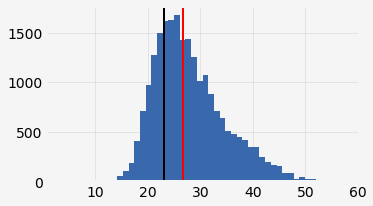

In [13]:
ax = train.sharpness.hist(bins=50)
ax.axvline(x=train.sharpness.median(), color='r');
ax.axvline(x=train.sharpness.quantile(.25), color='k');
print(f"The sharpness threshold {train.sharpness.quantile(.25):.2f}")

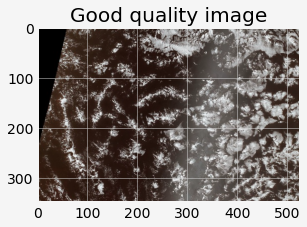

In [14]:
img_id_list = list(train.loc[train.sharpness >= 23.0, 'image_id'])
img = cv2.imread(train_path + img_id_list[0])
plt.title("Good quality image")
plt.imshow(img);

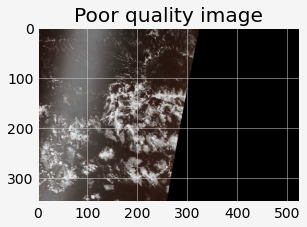

In [15]:
very_bad_img_id_list = list(train.loc[train.sharpness < 13.0, 'image_id'])
img = cv2.imread(train_path + very_bad_img_id_list[1])
plt.title("Poor quality image")
plt.imshow(img);

In [16]:
# read the original documentation
train = pd.read_csv('/content/train.zip')
train.shape

(22184, 2)

In [17]:
train["label"] = train["Image_Label"].apply(lambda x: x.split("_")[1])
train["im_id"] = train["Image_Label"].apply(lambda x: x.split("_")[0])

# only good images are used
train = train.loc[train["im_id"].isin(img_id_list), :]

sub = pd.read_csv(submission_path)
sub["label"] = sub["Image_Label"].apply(lambda x: x.split("_")[1])
sub["im_id"] = sub["Image_Label"].apply(lambda x: x.split("_")[0])

# split data
id_mask_count = (
    train.loc[train["EncodedPixels"].isnull() == False, "Image_Label"]
    .apply(lambda x: x.split("_")[0])
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"index": "img_id", "Image_Label": "count"})
)
ids = id_mask_count["img_id"].values
li = [
    [train_index, test_index]
    for train_index, test_index in StratifiedKFold(
        n_splits=N_FOLDS, random_state=SEED, shuffle=True,
    ).split(ids, id_mask_count["count"])
]
train_ids, valid_ids = ids[li[MODEL_NO][0]], ids[li[MODEL_NO][1]]
test_ids = sub["Image_Label"].apply(lambda x: x.split("_")[0]).drop_duplicates().values

print(f"training set   {train_ids[:5]}.. with length {len(train_ids)}")
print(f"validation set {valid_ids[:5]}.. with length {len(valid_ids)}")
print(f"testing set    {test_ids[:5]}.. with length {len(test_ids)}")

training set   ['0011165.jpg' '006c5a6.jpg' '008233e.jpg' '008a5ff.jpg' '0091591.jpg'].. with length 2772
validation set ['003994e.jpg' '009e2f3.jpg' '014310a.jpg' '0146ef3.jpg' '0153a8b.jpg'].. with length 1386
testing set    ['002f507.jpg' '0035ae9.jpg' '0038327.jpg' '004f759.jpg' '005ba08.jpg'].. with length 3698


In [18]:
# define dataset and dataloader
num_workers = 0 # to avoid any parallelization error, set this to 0
bs = 8
train_dataset = CloudDataset(
    df=train,
    datatype="train",
    img_ids=train_ids,
    img_dir=folder_path,
    subfolder = "train_images_525/",
    mask_subfolder = "train_masks_525/",
    transforms=get_training_augmentation(),
)
valid_dataset = CloudDataset(
    df=train,
    datatype="valid",
    img_ids=valid_ids,
    img_dir=folder_path,
    subfolder = "train_images_525/",
    mask_subfolder = "train_masks_525/",
    transforms=get_validation_augmentation(),
)

train_loader = DataLoader(
    train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers
)
valid_loader = DataLoader(
    valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers
)

## Model definition and set up

In [19]:
# one channel because images converted to grayscale
model = UNet(n_channels=3, n_classes=4).float()
if train_on_gpu:
    model.cuda()

In [20]:
model # print Model

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

In [21]:
criterion = BCEDiceLoss(eps=1.0, activation=None)
optimizer = RAdam(model.parameters(), lr = 0.005)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

## Training loop

In [22]:
# number of epochs to train the model
n_epochs = 32
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
epoch_bar = tq(range(1, n_epochs+1))
for epoch in epoch_bar:
    epoch_bar.set_description(f"Epoch {epoch:<4}")
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tq(train_loader, postfix={"train_loss":0.0})
    batch_nbr = 0
    for data, target in bar:
        bar.set_description(f"Training on batch {batch_nbr:<4}")
        batch_nbr += 1
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq(valid_loader, postfix={"valid_loss":0.0, "dice_score":0.0}, desc='validation')
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    dice_score = dice_score/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print(f'Epoch: {epoch}  Training Loss: {train_loss:.6f}  Validation Loss: {valid_loss:.6f} Dice Score: {dice_score:.6f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), folder_path + 'vanilla_unet.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 1  Training Loss: 1.085056  Validation Loss: 1.079060 Dice Score: 0.324645
Validation loss decreased (inf --> 1.079060).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 2  Training Loss: 0.994084  Validation Loss: 1.076086 Dice Score: 0.315411
Validation loss decreased (1.079060 --> 1.076086).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 3  Training Loss: 0.985606  Validation Loss: 0.984888 Dice Score: 0.404725
Validation loss decreased (1.076086 --> 0.984888).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 4  Training Loss: 0.974192  Validation Loss: 1.000464 Dice Score: 0.406412


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 5  Training Loss: 0.960429  Validation Loss: 0.970163 Dice Score: 0.395198
Validation loss decreased (0.984888 --> 0.970163).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 6  Training Loss: 0.951828  Validation Loss: 1.119446 Dice Score: 0.331818


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 7  Training Loss: 0.948417  Validation Loss: 1.040909 Dice Score: 0.430068


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 8  Training Loss: 0.935967  Validation Loss: 0.954188 Dice Score: 0.428694
Validation loss decreased (0.970163 --> 0.954188).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 9  Training Loss: 0.927048  Validation Loss: 0.976819 Dice Score: 0.420830


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 10  Training Loss: 0.930886  Validation Loss: 1.058062 Dice Score: 0.373034


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 11  Training Loss: 0.922131  Validation Loss: 1.082996 Dice Score: 0.385323


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 12  Training Loss: 0.883185  Validation Loss: 0.875059 Dice Score: 0.476035
Validation loss decreased (0.954188 --> 0.875059).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 13  Training Loss: 0.879421  Validation Loss: 0.868979 Dice Score: 0.475015
Validation loss decreased (0.875059 --> 0.868979).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 14  Training Loss: 0.871407  Validation Loss: 0.875408 Dice Score: 0.483625


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 15  Training Loss: 0.875771  Validation Loss: 0.865576 Dice Score: 0.473100
Validation loss decreased (0.868979 --> 0.865576).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 16  Training Loss: 0.868350  Validation Loss: 0.856964 Dice Score: 0.472405
Validation loss decreased (0.865576 --> 0.856964).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 17  Training Loss: 0.862070  Validation Loss: 0.862880 Dice Score: 0.476208


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 18  Training Loss: 0.863746  Validation Loss: 0.851654 Dice Score: 0.481328
Validation loss decreased (0.856964 --> 0.851654).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 19  Training Loss: 0.862255  Validation Loss: 0.881908 Dice Score: 0.481179


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 20  Training Loss: 0.850395  Validation Loss: 0.877678 Dice Score: 0.478363


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 21  Training Loss: 0.853201  Validation Loss: 0.856243 Dice Score: 0.495213


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 22  Training Loss: 0.844942  Validation Loss: 0.831509 Dice Score: 0.502481
Validation loss decreased (0.851654 --> 0.831509).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 23  Training Loss: 0.845692  Validation Loss: 0.831322 Dice Score: 0.494608
Validation loss decreased (0.831509 --> 0.831322).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 24  Training Loss: 0.839437  Validation Loss: 0.833078 Dice Score: 0.501118


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 25  Training Loss: 0.839309  Validation Loss: 0.829846 Dice Score: 0.502247
Validation loss decreased (0.831322 --> 0.829846).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 26  Training Loss: 0.835622  Validation Loss: 0.832380 Dice Score: 0.502515


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 27  Training Loss: 0.838606  Validation Loss: 0.826735 Dice Score: 0.500489
Validation loss decreased (0.829846 --> 0.826735).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 28  Training Loss: 0.835579  Validation Loss: 0.831266 Dice Score: 0.497067


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 29  Training Loss: 0.836176  Validation Loss: 0.831314 Dice Score: 0.500365


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 30  Training Loss: 0.836305  Validation Loss: 0.825329 Dice Score: 0.501077
Validation loss decreased (0.826735 --> 0.825329).  Saving model ...


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 31  Training Loss: 0.830808  Validation Loss: 0.829956 Dice Score: 0.498364


  0%|          | 0/347 [00:00<?, ?it/s, train_loss=0]

validation:   0%|          | 0/174 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 32  Training Loss: 0.835443  Validation Loss: 0.831151 Dice Score: 0.497769


## Ploting Metrics

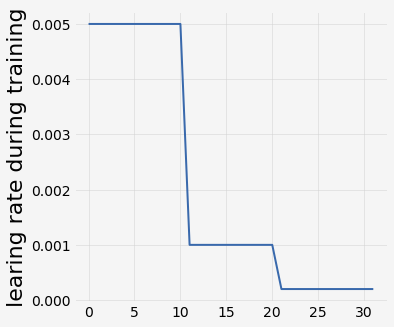

In [23]:
plt.figure(figsize=(5,5))
plt.plot([i[0] for i in lr_rate_list])
plt.ylabel('learing rate during training', fontsize=22)
plt.show()

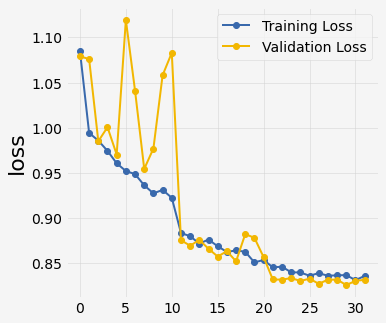

In [24]:
plt.figure(figsize=(5,5))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

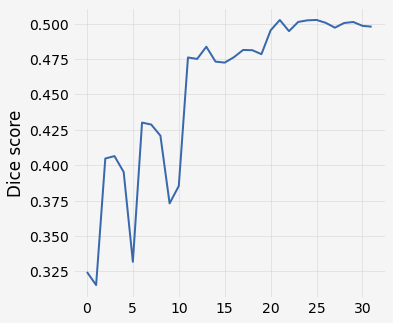

In [25]:
plt.figure(figsize=(5,5))
plt.plot(dice_score_list)
plt.ylabel('Dice score')
plt.show()

In [26]:
# load best model
model.load_state_dict(torch.load(folder_path + 'vanilla_unet.pt'))
model.eval();

In [113]:
valid_masks = []
count = 0
tr = min(len(valid_ids)*4, 2000)
probabilities = np.zeros((tr, 350, 525), dtype = np.float32)
valid_bar = tq(valid_loader)
val_batch_nbr = 0
for data, target in valid_bar:
    valid_bar.set_description(f"Validating on batch nbr {val_batch_nbr:4}")
    val_batch_nbr += 1
    if train_on_gpu:
        data = data.cuda()
    target = target.cpu().detach().numpy()
    outpu = model(data).cpu().detach().numpy()
    for p in range(data.shape[0]):
        output, mask = outpu[p], target[p]
        for m in mask:
            valid_masks.append(resize(m))
        for probability in output:
            probabilities[count, :, :] = resize(probability)
            count += 1
        if count >= tr - 1:
            break
    if count >= tr - 1:
        break

  0%|          | 0/174 [00:00<?, ?it/s]

In [110]:
def resize(img, 
           img_size = (350, 525)):
    """resize an image, if user supplied size is different from original size

    Parameters
    ----------
    img : np.array
        original image to resize
    img_size : tuple, optional
        target image size, by default ((350, 525)

    Returns
    -------
    np.array
        resized image
    """
    if img.shape != img_size:
        cv2_img_size = tuple(reversed(img_size))
        return cv2.resize(img, dsize=cv2_img_size, interpolation=cv2.INTER_LINEAR)
    else:
        return img

In [114]:
valid_masks = []
count = 0
tr = min(len(valid_ids)*4, 2000)
probabilities = np.zeros((tr, 350, 525), dtype = np.float32)
val_batch_nbr = 0
for data, target in valid_bar:
    valid_bar.set_description(f"Validating on batch nbr {val_batch_nbr:4}")
    val_batch_nbr += 1
    if train_on_gpu:
        data = data.cuda()
    target = target.cpu().detach().numpy()
    outpu = model(data).cpu().detach().numpy()
    for p in range(data.shape[0]):
        output, mask = outpu[p], target[p]
        for m in mask:
            valid_masks.append(resize(m))
        for probability in output:
            probabilities[count, :, :] = resize(probability)
            count += 1
        if count >= tr - 1:
            break
    if count >= tr - 1:
        break

## Grid Search for best Threshold

In [115]:
class_params = {}
for class_id in range(4):
    print(class_id)
    attempts = []
    for t in range(0, 100, 5):
        t /= 100
        for ms in [0, 100, 1200, 5000, 10000, 30000]:
            masks, d = [], []
            for i in range(class_id, len(probabilities), 4):
                probability = probabilities[i]
                predict, num_predict = post_process(probability, t, ms)
                masks.append(predict)
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))
            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    class_params[class_id] = (best_threshold, best_size)

0
    threshold   size      dice
41       0.30  30000  0.564352
53       0.40  30000  0.561259
47       0.35  30000  0.558340
59       0.45  30000  0.552031
65       0.50  30000  0.549532
1
    threshold   size      dice
47       0.35  30000  0.736969
41       0.30  30000  0.736094
94       0.75  10000  0.734680
35       0.25  30000  0.734607
88       0.70  10000  0.732471
2
    threshold   size      dice
47       0.35  30000  0.582333
53       0.40  30000  0.580183
65       0.50  30000  0.579039
59       0.45  30000  0.579020
71       0.55  30000  0.578426
3
    threshold   size      dice
88       0.70  10000  0.573754
94       0.75  10000  0.569939
76       0.60  10000  0.567092
70       0.55  10000  0.566353
82       0.65  10000  0.564942


In [116]:
del masks
del valid_masks
del probabilities
gc.collect()

270617

In [117]:
attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
print(class_params)

{0: (0.3, 30000), 1: (0.35, 30000), 2: (0.35, 30000), 3: (0.7, 10000)}


In [118]:
attempts_df.groupby(['threshold'])['dice'].max()

threshold
0.00    0.283691
0.05    0.439914
0.10    0.493147
0.15    0.523026
0.20    0.529629
0.25    0.541785
0.30    0.548384
0.35    0.548928
0.40    0.553873
0.45    0.559295
0.50    0.563209
0.55    0.566353
0.60    0.567092
0.65    0.564942
0.70    0.573754
0.75    0.569939
0.80    0.553940
0.85    0.526904
0.90    0.486191
0.95    0.400100
Name: dice, dtype: float64

In [119]:
attempts_df.groupby(['size'])['dice'].max()

size
0        0.504750
100      0.512614
1200     0.536607
5000     0.559026
10000    0.573754
30000    0.538537
Name: dice, dtype: float64

In [120]:
attempts_df = attempts_df.sort_values('dice', ascending=False)
attempts_df.head(10)

threshold   size      dice
88        0.70  10000  0.573754
94        0.75  10000  0.569939
76        0.60  10000  0.567092
70        0.55  10000  0.566353
82        0.65  10000  0.564942
64        0.50  10000  0.563209
58        0.45  10000  0.559295
81        0.65   5000  0.559026
87        0.70   5000  0.558691
100       0.80  10000  0.553940

In [121]:
attempts_df.to_csv("grid_search_thres.csv")

In [86]:
sc_map = sc.ScicoQualitative(cmap='colorblind')
sc_cmap = sc_map.get_mpl_color_map()
mpl.cm.register_cmap("sc_cb", sc_cmap)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Trying to register the cmap 'sc_cb' which already exists.
  This is separate from the ipykernel package so we can avoid doing imports until


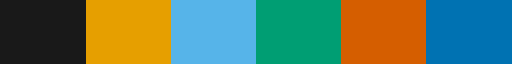

In [87]:
sc_cmap

In [122]:
attempts_df = pd.read_csv('grid_search_thres.csv', index_col=0)
attempts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 88 to 0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   threshold  120 non-null    float64
 1   size       120 non-null    int64  
 2   dice       120 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.8 KB


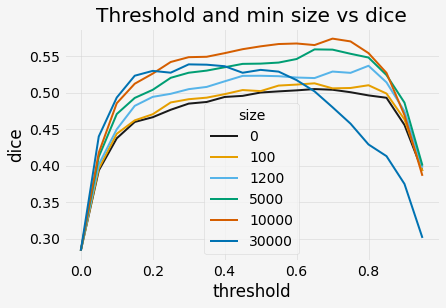

In [123]:
fig, ax = plt.subplots(figsize=(6, 4))
attempts_df['size'] = attempts_df['size'].astype("category")
ax = sns.lineplot(x='threshold', 
                   y='dice',
                   data=attempts_df, 
                   hue='size', 
                   palette='sc_cb', 
                   ax=ax)
ax.set_title('Threshold and min size vs dice');
fig.savefig("gridsearch_thres.png")

In [124]:
best_threshold = attempts_df['threshold'].values[0]
best_size = attempts_df['size'].values[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

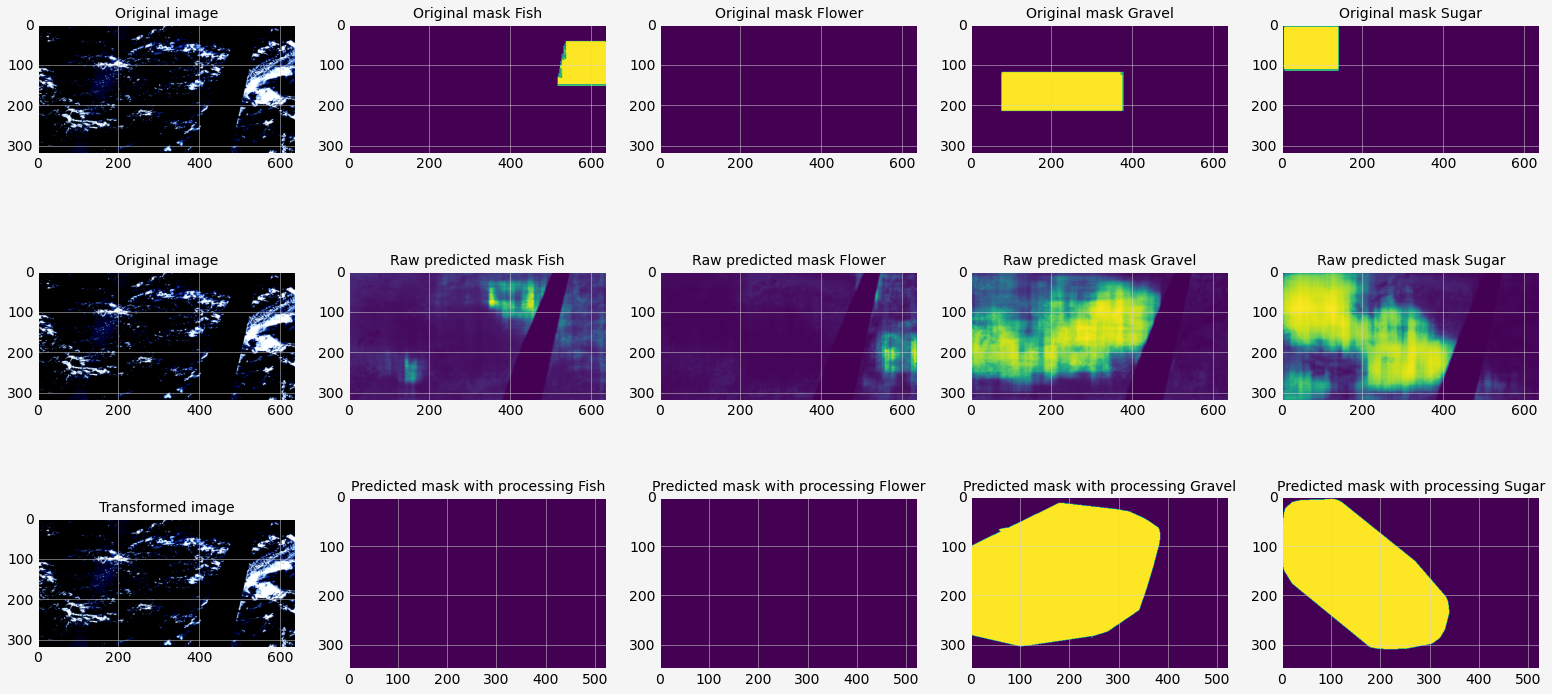

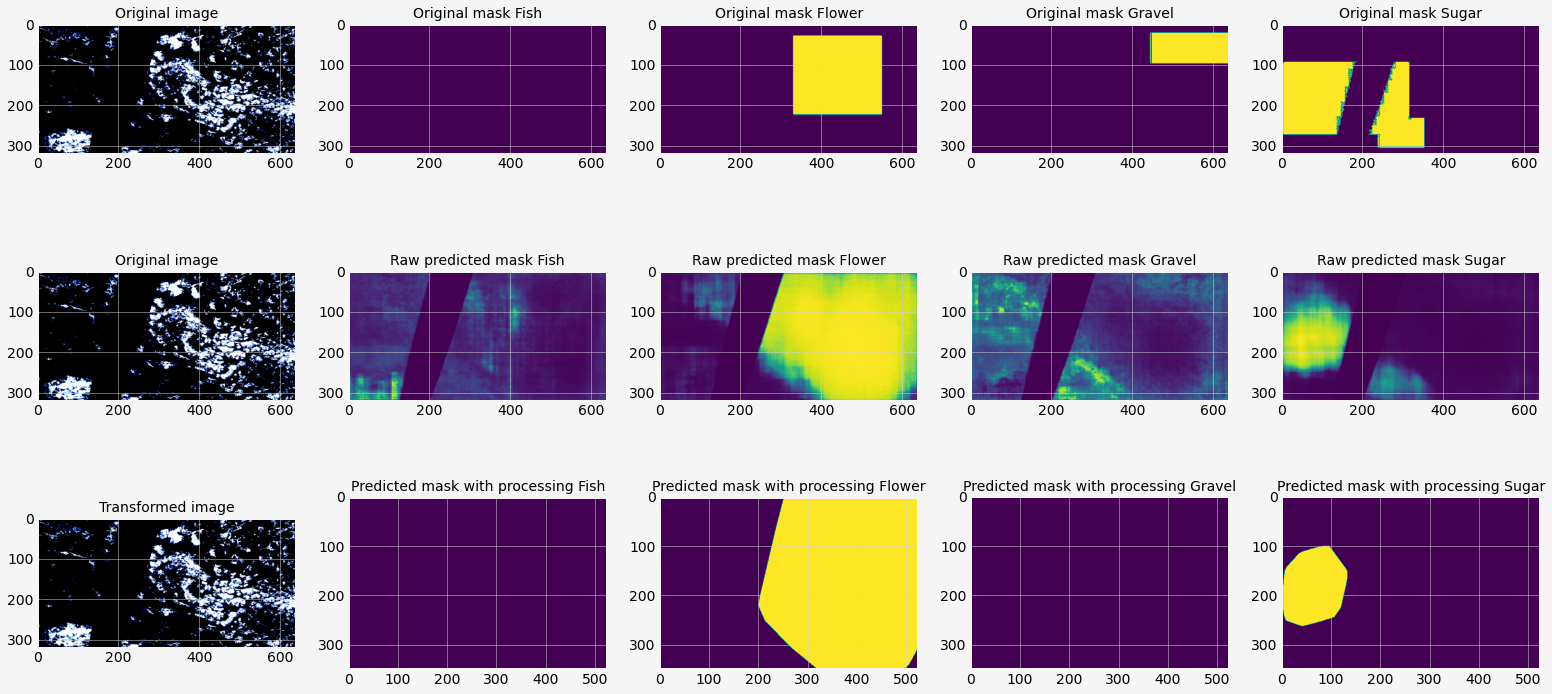

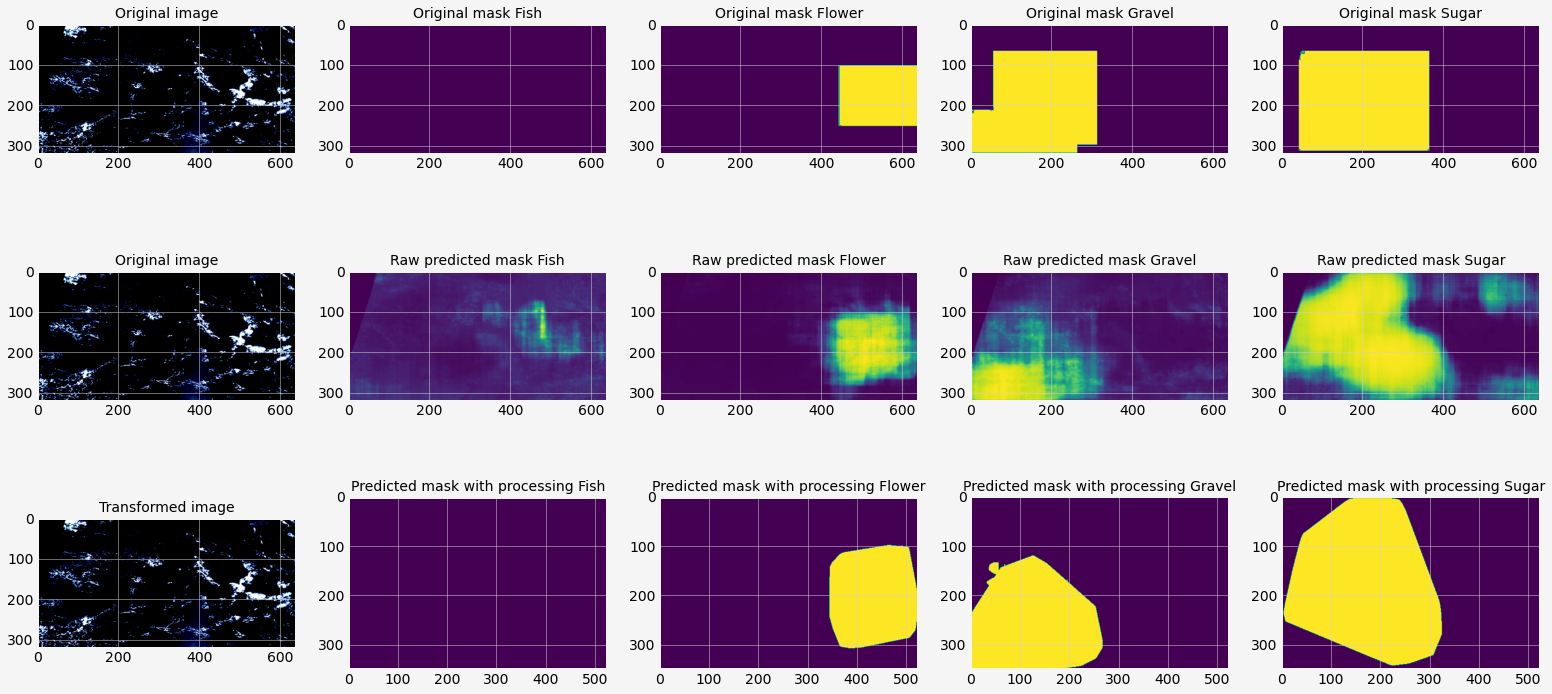

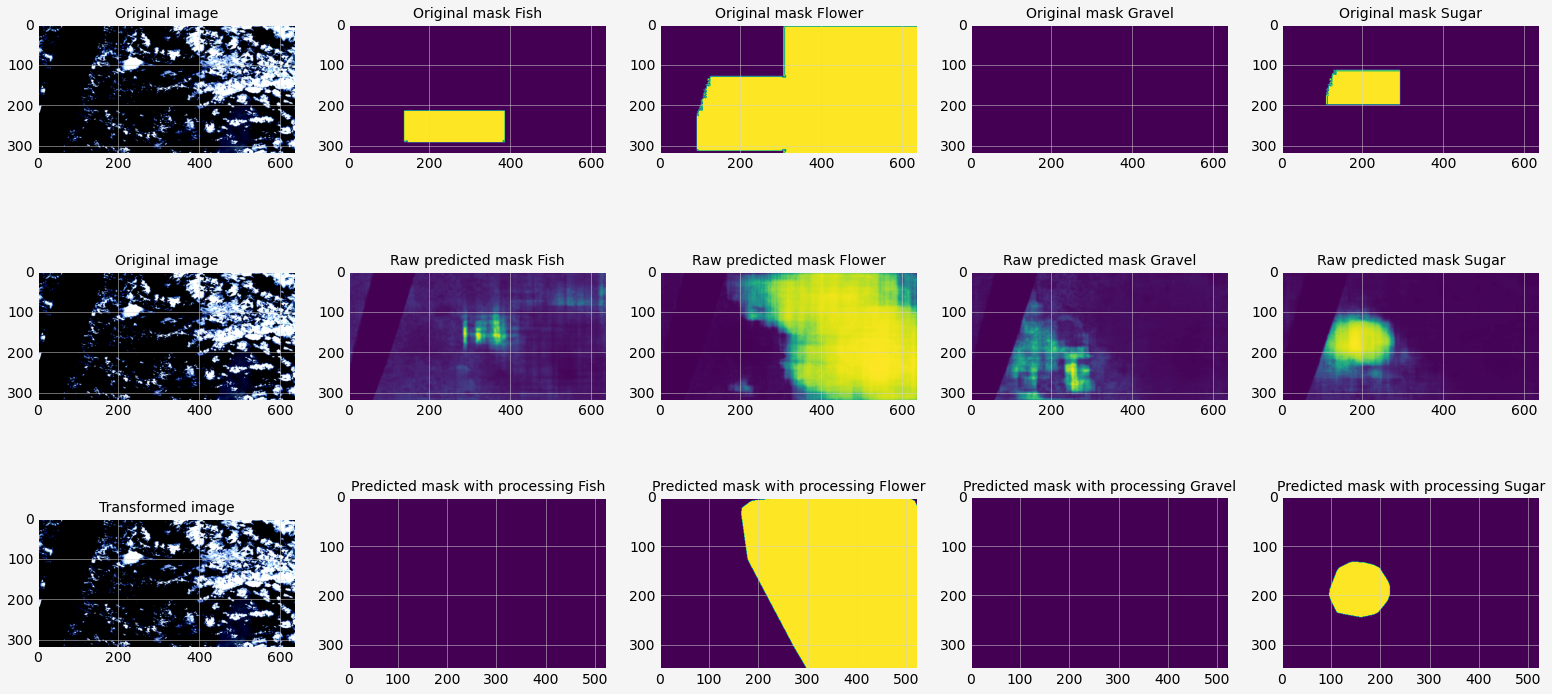

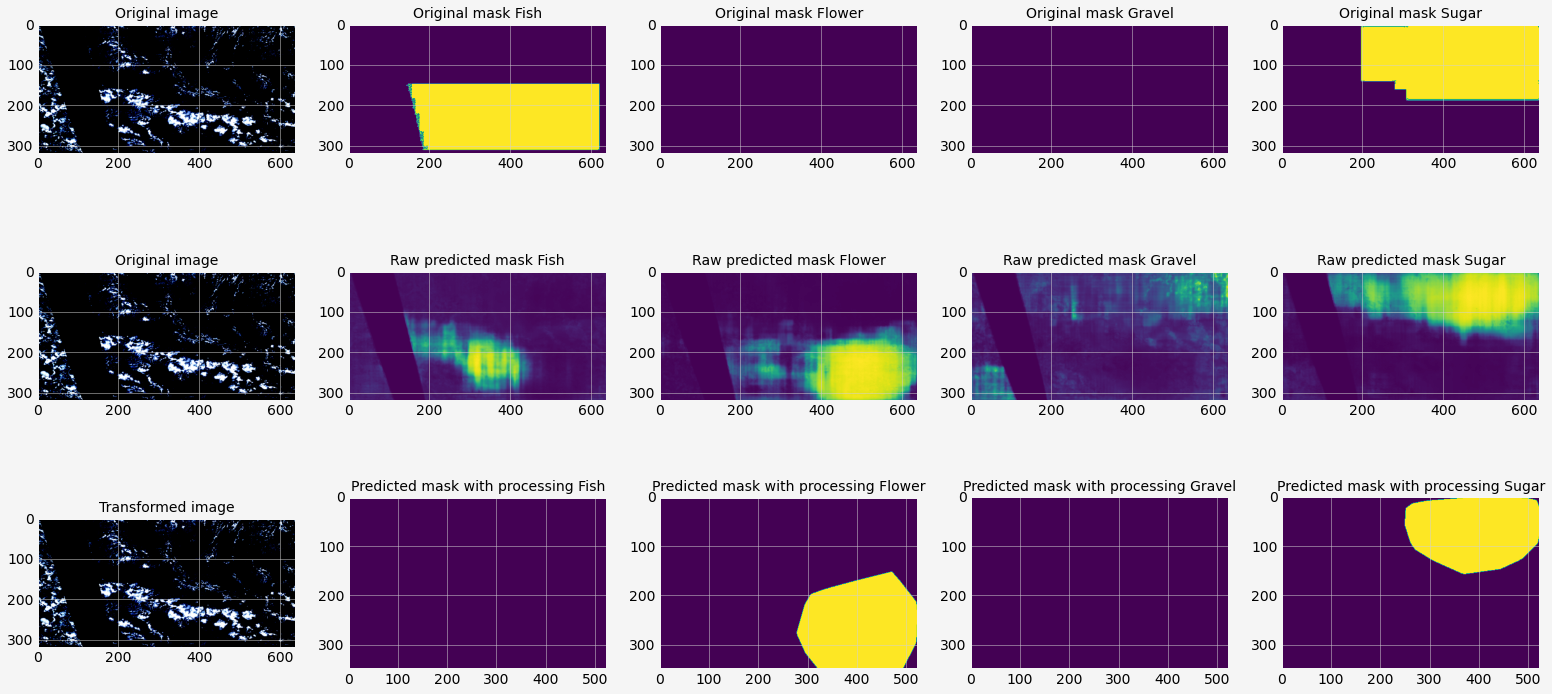

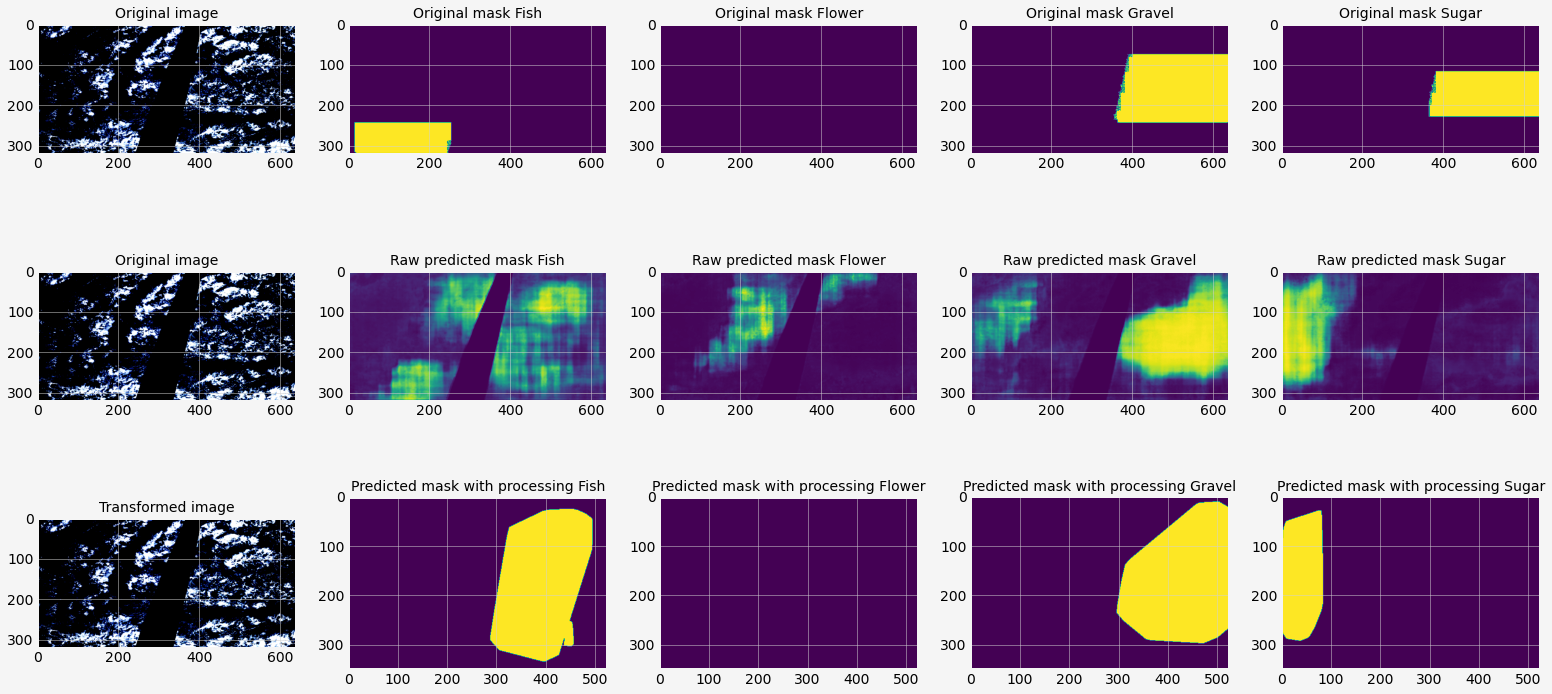

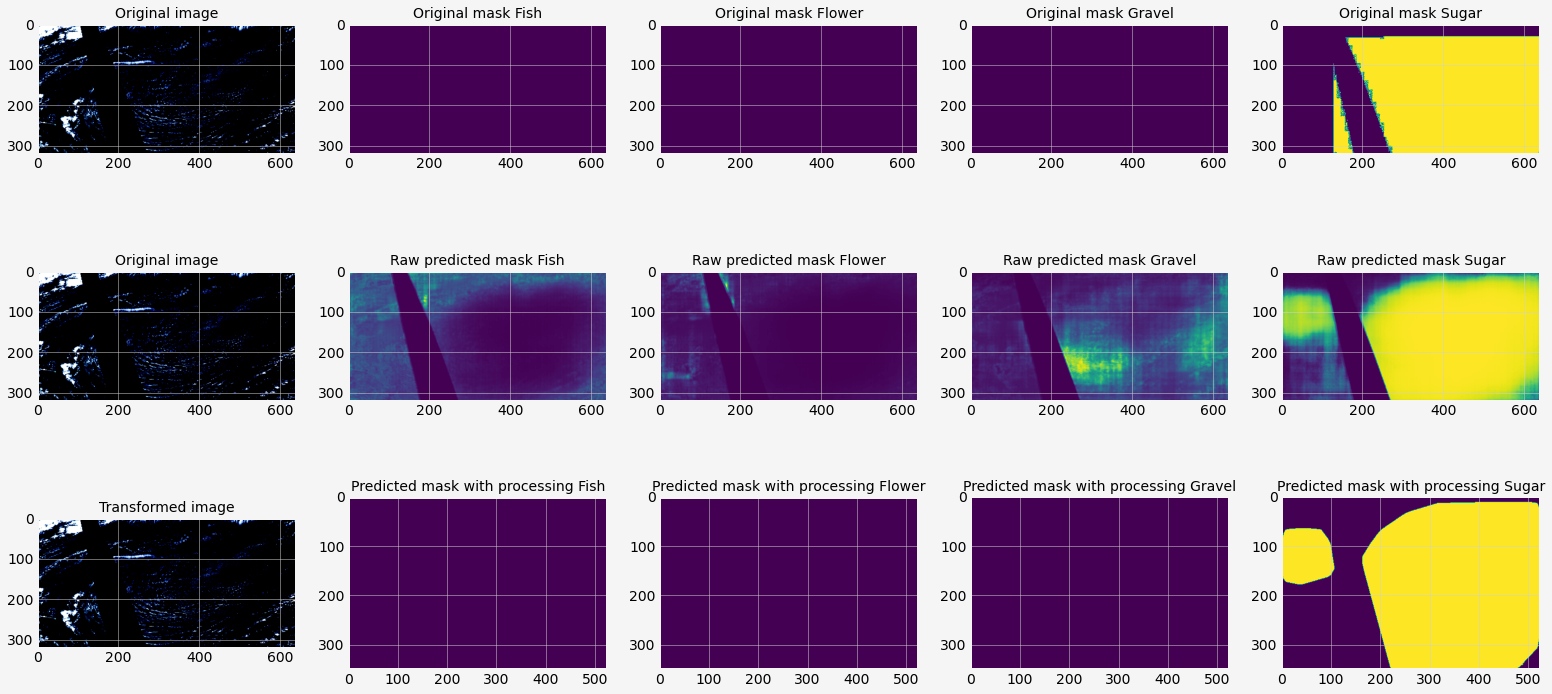

In [125]:
for i, (data, target) in enumerate(valid_loader):
    if train_on_gpu:
        data = data.cuda()
    output = ((model(data))[0]).cpu().detach().numpy()
    image  = data[0].cpu().detach().numpy()
    mask   = target[0].cpu().detach().numpy()
    output = output.transpose(1 ,2, 0)
    image_vis = image.transpose(1, 2, 0)
    mask = mask.astype('uint8').transpose(1, 2, 0)
    pr_mask = np.zeros((350, 525, 4))
    for j in range(4):
        probability = resize(output[:, :, j])
        pr_mask[:, :, j], _ = post_process(probability,
                                           class_params[j][0],
                                           class_params[j][1])
    visualize_with_raw(image=image_vis, mask=pr_mask,
                      original_image=image_vis, original_mask=mask,
                      raw_image=image_vis, raw_mask=output)
    if i >= 6:
        break

In [126]:
torch.cuda.empty_cache()
gc.collect()

269068

In [141]:
test_dataset = CloudDataset(df=sub,
                            datatype='test', 
                            img_ids=test_ids,
                            img_dir=folder_path,
                            subfolder = "test_images_525/",
                            mask_subfolder = "train_masks_525/",
                            transforms=get_validation_augmentation())
test_loader = DataLoader(test_dataset, 
                         batch_size=4,
                         shuffle=False, 
                         num_workers=2)

In [143]:
del train_dataset, train_loader
del valid_dataset, valid_loader
gc.collect()

## Compute scores on the test set

In [144]:
subm = pd.read_csv(submission_path)
pathlist = [test_path + i.split("_")[0] for i in subm['Image_Label']]

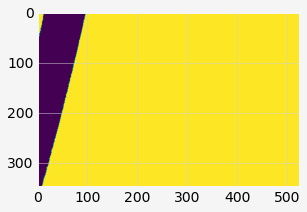

In [145]:
def get_black_mask(image_path):
    img = cv2.imread(image_path) 
    img = cv2.resize(img, dsize=tuple((525,350)), interpolation=cv2.INTER_LINEAR)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 0], np.uint8)
    upper = np.array([180, 255, 10], np.uint8)
    return (~ (cv2.inRange(hsv, lower, upper) > 250)).astype(int)

plt.imshow(get_black_mask(pathlist[120]))
plt.show();

In [146]:
encoded_pixels = []
image_id = 0
cou = 0
np_saved = 0
for data, target in tq(test_loader):
    if train_on_gpu:
        data = data.cuda()
    output = model(data)
    del data
    for i, batch in enumerate(output):
        for probability in batch:
            probability = resize(probability.cpu().detach().numpy())
            predict, num_predict = post_process(probability,
                                                class_params[image_id % 4][0],
                                                class_params[image_id % 4][1])
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                black_mask = get_black_mask(pathlist[cou])
                np_saved += np.sum(predict)
                predict = np.multiply(predict, black_mask)
                np_saved -= np.sum(predict)
                r = mask_to_rle(predict)
                encoded_pixels.append(r)
            cou += 1
            image_id += 1

print(f"number of pixel saved {np_saved}")

  0%|          | 0/925 [00:00<?, ?it/s]

number of pixel saved 525772.0


In [147]:
sub['EncodedPixels'] = encoded_pixels
sub.to_csv('unet_vanilla_pred_test.csv', columns=['Image_Label', 'EncodedPixels'], index=False)